In [1]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [2]:
# Imports

import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import copy
pd.options.plotting.backend = "matplotlib"
import json



In [3]:
# beautify graphs.

sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('font', size=11)          # controls default text sizes

palatte=sns.color_palette('pastel')
palatte

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [4]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, label=None, ax=None,  color='red', linewidth=1, std_dev=1.5):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    ax = sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Stable Entropy Baselines

In [5]:
NUM_SEQ=1000
MAX_LEN=128
WIDTH=5
MAX_SOURCE_LEN=1024
STD_DEV=1.5


## Text Completion

In [6]:
# Text Completion data
wikipedia_text_completion = "data/rankgen/wiki.jsonl"
cc_news = "data/cc_news/generated/orig.jsonl"
writing_prompts = "data/writingPrompts/generated/orig.jsonl"

In [7]:
# GPT-2 XL Model
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b", device_map="balanced")

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
wikipedia_dataframe = pd.read_json(wikipedia_text_completion, lines=True)
cc_news_dataframe = pd.read_json(cc_news, lines=True)

with open(writing_prompts) as f:
    objs = []
    for line in f:
        objs.append(json.loads(line))
writing_prompts_dataframe = pd.DataFrame(objs)

In [9]:
wikipedia_dataframe['model_text'] = wikipedia_dataframe['targets'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
wikipedia_dataframe['context'] = wikipedia_dataframe['prefix']

writing_prompts_dataframe = writing_prompts_dataframe[:1000]
cc_news_dataframe = cc_news_dataframe[:1000]

### Entropy Baseline (Smoothed) for Gemma-2B for Wikipedia and CC News

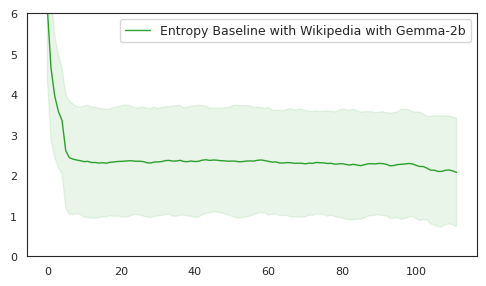

In [11]:
sns.set_style('white') # darkgrid, white grid, dark, white and ticks
# Wikipedia and GPT-2 XL
dataframe, dataset_name = (wikipedia_dataframe, "Wikipedia")
num_seq = min(NUM_SEQ, len(dataframe))
wiki_gemma_avgs, wiki_gemma_ma_entropies = compute_average_across_sequences(wikipedia_dataframe, model, tokenizer, column_prefix='human_generated', width=5,  max_len=1024, to_be_averaged='entropy_ma', num_seq=num_seq, cache=True,  max_source_len=256, is_seq2seq=False)

num_non_zero_seq = np.sum(np.sum(wiki_gemma_ma_entropies.mask == 0, axis=0) > num_seq * 0.25)
wiki_gemma_ma_entropies = wiki_gemma_ma_entropies[:, 0:num_non_zero_seq]

fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
plot_avg_entropies_mean_std(wiki_gemma_ma_entropies, 
    label=f"Entropy Baseline with {dataset_name} with Gemma-2b", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right",)
ax.tick_params(labelsize=8)


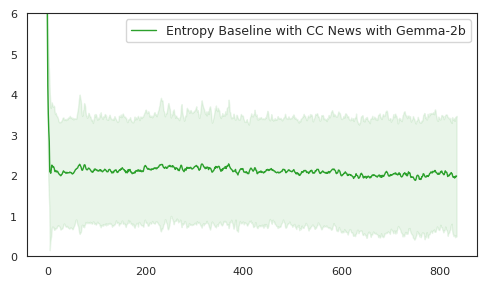

In [12]:
# CC News and Gemma-2B
dataframe, dataset_name = (cc_news_dataframe, "CC News")
_, cc_gemma_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=5,  max_len=1024, to_be_averaged='entropy_ma', num_seq=1000, cache=True)

num_non_zero_seq = np.sum(np.sum(cc_gemma_ma_entropies.mask == 0, axis=0) > num_seq * 0.25)
cc_gemma_ma_entropies = cc_gemma_ma_entropies[:, 0:num_non_zero_seq]

fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
plot_avg_entropies_mean_std(cc_gemma_ma_entropies, 
    label=f"Entropy Baseline with {dataset_name} with Gemma-2b", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right")
ax.tick_params(labelsize=8)

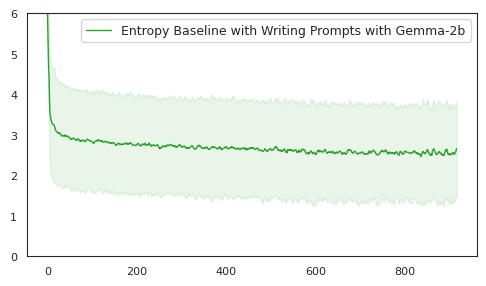

In [13]:
# Writing Prompts and Gemma-2B
dataframe, dataset_name = (writing_prompts_dataframe, "Writing Prompts")
_, cc_gemma_ma_entropies = compute_average_across_sequences(writing_prompts_dataframe, model, tokenizer, column_prefix='human_generated', width=5,  max_len=1024, to_be_averaged='entropy_ma', num_seq=1000, cache=True)

num_non_zero_seq = np.sum(np.sum(cc_gemma_ma_entropies.mask == 0, axis=0) > num_seq * 0.25)
cc_gemma_ma_entropies = cc_gemma_ma_entropies[:, 0:num_non_zero_seq]

fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
plot_avg_entropies_mean_std(cc_gemma_ma_entropies, 
    label=f"Entropy Baseline with {dataset_name} with Gemma-2b", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right")
ax.tick_params(labelsize=8)

### Negative Log Likelihood Baseline (Smoothed) for Gemma-2B for Wikipedia and CC News

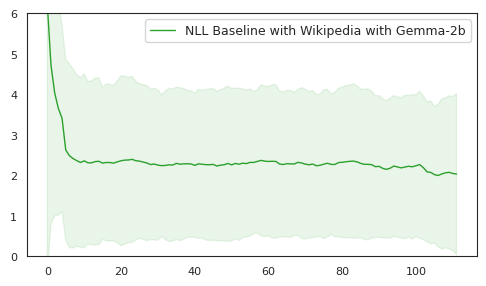

In [14]:
sns.set_style('white') # darkgrid, white grid, dark, white and ticks
# Wikipedia and GPT-2 XL
dataframe, dataset_name = (wikipedia_dataframe, "Wikipedia")
num_seq = min(NUM_SEQ, len(dataframe))
wiki_gemma_avgs, wiki_gemma_ma_entropies = compute_average_across_sequences(wikipedia_dataframe, model, tokenizer, column_prefix='human_generated', width=5,  max_len=1024, to_be_averaged='log_prob_ma', num_seq=num_seq, cache=True,  max_source_len=256, is_seq2seq=False)

num_non_zero_seq = np.sum(np.sum(wiki_gemma_ma_entropies.mask == 0, axis=0) > num_seq * 0.25)
wiki_gemma_ma_entropies = wiki_gemma_ma_entropies[:, 0:num_non_zero_seq]

fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
plot_avg_entropies_mean_std(wiki_gemma_ma_entropies, 
    label=f"NLL Baseline with {dataset_name} with Gemma-2b", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right",)
ax.tick_params(labelsize=8)

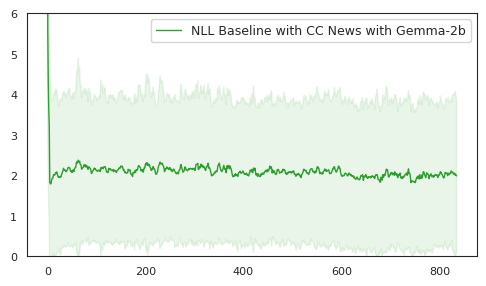

In [15]:
# CC News and Gemma-2B
dataframe, dataset_name = (cc_news_dataframe, "CC News")
_, cc_gemma_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=5,  max_len=1024, to_be_averaged='log_prob_ma', num_seq=1000, cache=True)

num_non_zero_seq = np.sum(np.sum(cc_gemma_ma_entropies.mask == 0, axis=0) > num_seq * 0.25)
cc_gemma_ma_entropies = cc_gemma_ma_entropies[:, 0:num_non_zero_seq]

fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
plot_avg_entropies_mean_std(cc_gemma_ma_entropies, 
    label=f"NLL Baseline with {dataset_name} with Gemma-2b", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right")
ax.tick_params(labelsize=8)

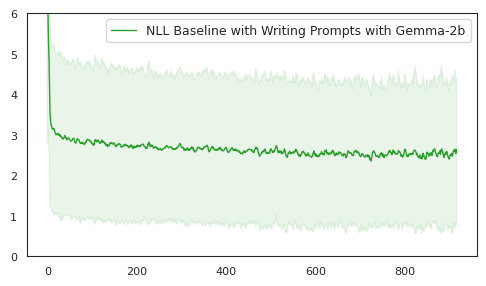

In [18]:
# Writing Prompts and Gemma-2B
dataframe, dataset_name = (writing_prompts_dataframe, "Writing Prompts")
_, cc_gemma_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=5,  max_len=1024, to_be_averaged='log_prob_ma', num_seq=1000, cache=True)

num_non_zero_seq = np.sum(np.sum(cc_gemma_ma_entropies.mask == 0, axis=0) > num_seq * 0.25)
cc_gemma_ma_entropies = cc_gemma_ma_entropies[:, 0:num_non_zero_seq]

fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
plot_avg_entropies_mean_std(cc_gemma_ma_entropies, 
    label=f"NLL Baseline with {dataset_name} with Gemma-2b", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right")
ax.tick_params(labelsize=8)

# Correlation Plots for Writing Prompts with Gemma-2B

In [10]:
correlation_data = pd.read_csv('data/text_completion/writing_prompts/corr_analysis/nex_2048/mpl_256/ml_1024/google/gemma-2b/compiled_results.csv', index_col=0)
correlation_data['Decoding Method'] = correlation_data['dataset'].str.extract("(top_k|temp|top_p|typical|beam|greedy)")
correlation_data['temperature'] = correlation_data['dataset'].str.extract("(temp_[0-9.]+)")[0].str.extract(r'(\d+.\d+)').astype('float')

'data/text_completion/writing_prompts/corr_analysis/nex_2048/mpl_256/ml_1024/google/gemma-2b/typical_p_0.25_run_1.jsonl'

In [11]:
correlation_data.loc[ correlation_data['temperature'] > 1, 'Decoding Method'] = "temp > 1"
correlation_data.loc[ correlation_data['temperature'] < 1, 'Decoding Method'] = "temp < 1"
correlation_data.loc[correlation_data['temperature'] == 1, 'Decoding Method'] = "temp = 1"

In [12]:
markers = {'greedy': "8", "beam": "h", "temp = 1": "s", "temp > 1": "^", "temp < 1": "v", "typical": "X", "top_p": "p", "top_k": "d"}

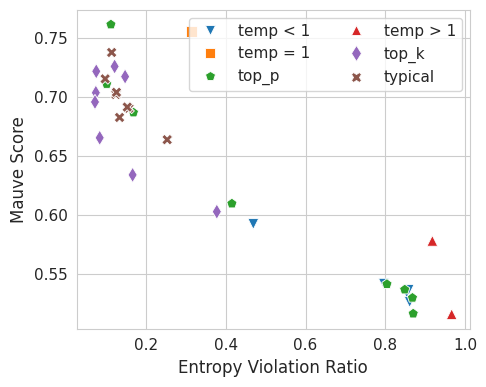

In [13]:
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='entropy_violation_ratio', y='mauve', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Violation Ratio")
ax.set_ylabel("Mauve Score")
sns.move_legend(ax, loc="upper right", ncol=2, title=None)

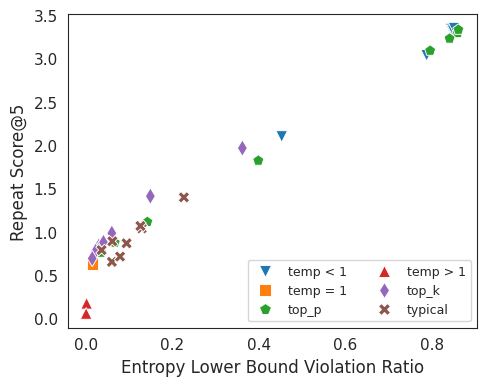

In [14]:
plt.rc('legend', fontsize=9)    # legend fontsize
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='lower_bound_violation_ratio', y='repeat_score@5', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=70)
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Lower Bound Violation Ratio")
ax.set_ylabel("Repeat Score@5")
sns.move_legend(ax, loc="lower right", ncol=2, title=None)


# Correlation Plots for Wiki+Gemma

In [21]:
correlation_data = pd.read_csv('data/text_completion/rankgen_wiki/corr_analysis/nex_8192/mpl_256/ml_1024/google/gemma-2b/compiled_results.csv', index_col=0)
correlation_data['Decoding Method'] = correlation_data['dataset'].str.extract("(top_k|temp|top_p|typical|beam|greedy)")
correlation_data['temperature'] = correlation_data['dataset'].str.extract("(temp_[0-9.]+)")[0].str.extract(r'(\d+.\d+)').astype('float')

In [22]:
correlation_data.loc[ correlation_data['temperature'] > 1, 'Decoding Method'] = "temp > 1"
correlation_data.loc[ correlation_data['temperature'] < 1, 'Decoding Method'] = "temp < 1"
correlation_data.loc[correlation_data['temperature'] == 1, 'Decoding Method'] = "temp = 1"

In [23]:
markers = {'greedy': "8", "beam": "h", "temp = 1": "s", "temp > 1": "^", "temp < 1": "v", "typical": "X", "top_p": "p", "top_k": "d"}

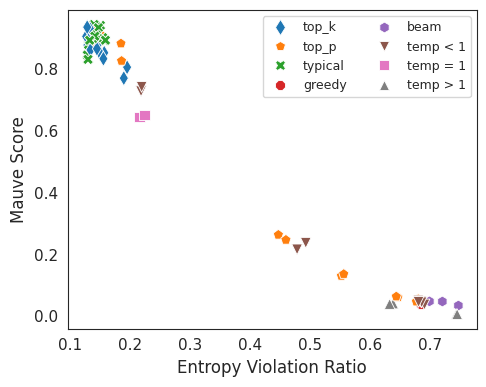

In [24]:
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='entropy_violation_ratio', y='mauve', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Violation Ratio")
ax.set_ylabel("Mauve Score")
sns.move_legend(ax, loc="upper right", ncol=2, title=None)

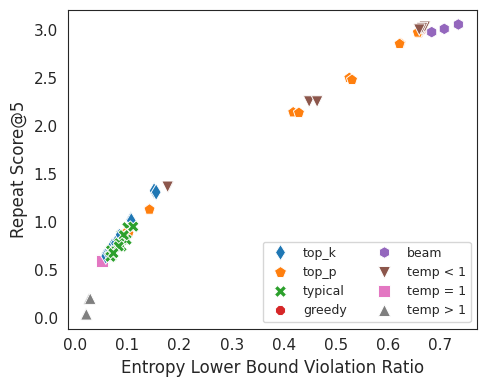

In [25]:
plt.rc('legend', fontsize=9)    # legend fontsize
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='lower_bound_violation_ratio', y='repeat_score@5', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=70)
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Lower Bound Violation Ratio")
ax.set_ylabel("Repeat Score@5")
sns.move_legend(ax, loc="lower right", ncol=2, title=None)
